# Tutorial PyMC

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats

In [2]:
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

# Mean Poisson values
theta_noalcohol_meds = 1  # no alcohol, took an antihist
theta_alcohol_meds = 3  # alcohol, took an antihist
theta_noalcohol_nomeds = 6  # no alcohol, no antihist
theta_alcohol_nomeds = 36  # alcohol, no antihist

# Gamma shape parameter
alpha = 10


def get_nb_vals(mu, alpha, size):
    """Generate negative binomially distributed samples by
    drawing a sample from a gamma distribution with mean `mu` and
    shape parameter `alpha', then drawing from a Poisson
    distribution whose rate parameter is given by the sampled
    gamma variable.

    """

    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


# Create samples
n = 1000
df = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            (
                get_nb_vals(theta_noalcohol_meds, alpha, n),
                get_nb_vals(theta_alcohol_meds, alpha, n),
                get_nb_vals(theta_noalcohol_nomeds, alpha, n),
                get_nb_vals(theta_alcohol_nomeds, alpha, n),
            )
        ),
        "alcohol": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(False, n),
                np.repeat(True, n),
            )
        ),
        "nomeds": np.concatenate(
            (
                np.repeat(False, n),
                np.repeat(False, n),
                np.repeat(True, n),
                np.repeat(True, n),
            )
        ),
    }
)
df

,nsneeze,alcohol,nomeds
0,2,False,False
1,1,False,False
2,3,False,False
3,0,False,False
4,0,False,False
...,...,...,...
3995,28,True,True
3996,23,True,True
3997,44,True,True
3998,20,True,True


In [3]:
df.describe()

,nsneeze
count,4000.000000
mean,11.348000
std,15.514737
min,0.000000
25%,1.000000
50%,4.000000
75%,13.000000
max,94.000000


In [4]:
df.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
nomeds alcohol                    
False  False     0.960    1.017417
       True      3.021    3.982542
True   False     5.950    9.094595
       True     35.461  160.843322

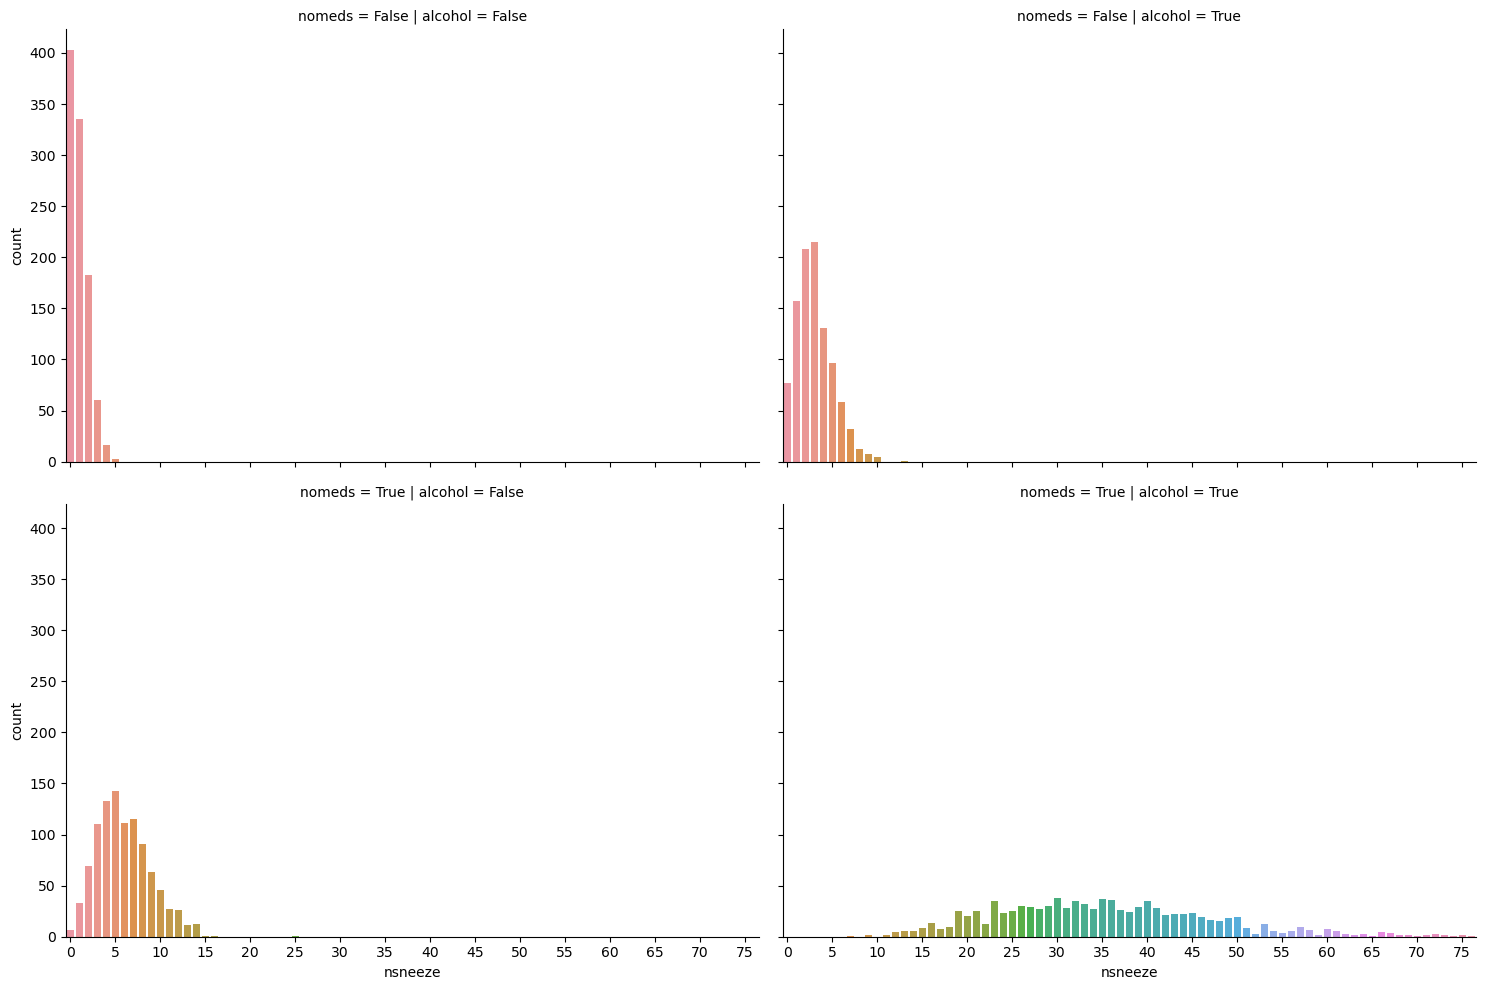

In [5]:
g = sns.catplot(x="nsneeze", row="nomeds", col="alcohol", data=df, kind="count", aspect=1.5)

# Make x-axis ticklabels less crowded
ax = g.axes[1, 0]
labels = range(len(ax.get_xticklabels(which="both")))
ax.set_xticks(labels[::5])
ax.set_xticklabels(labels[::5]);

In [6]:
COORDS = {"regressor": ["nomeds", "alcohol", "nomeds:alcohol"], "obs_idx": df.index}

with pm.Model(coords=COORDS) as m_sneeze_inter:
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    alpha = pm.Exponential("alpha", 0.5)

    M = pm.ConstantData("nomeds", df.nomeds.to_numpy(), dims="obs_idx")
    A = pm.ConstantData("alcohol", df.alcohol.to_numpy(), dims="obs_idx")
    S = pm.ConstantData("nsneeze", df.nsneeze.to_numpy(), dims="obs_idx")

    λ = pm.math.exp(a + b[0] * M + b[1] * A + b[2] * M * A)

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=S, dims="obs_idx")

    idata = pm.sample()
    pp = pm.sample_prior_predictive(samples=100, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Sampling: [alpha, intercept, slopes, y]


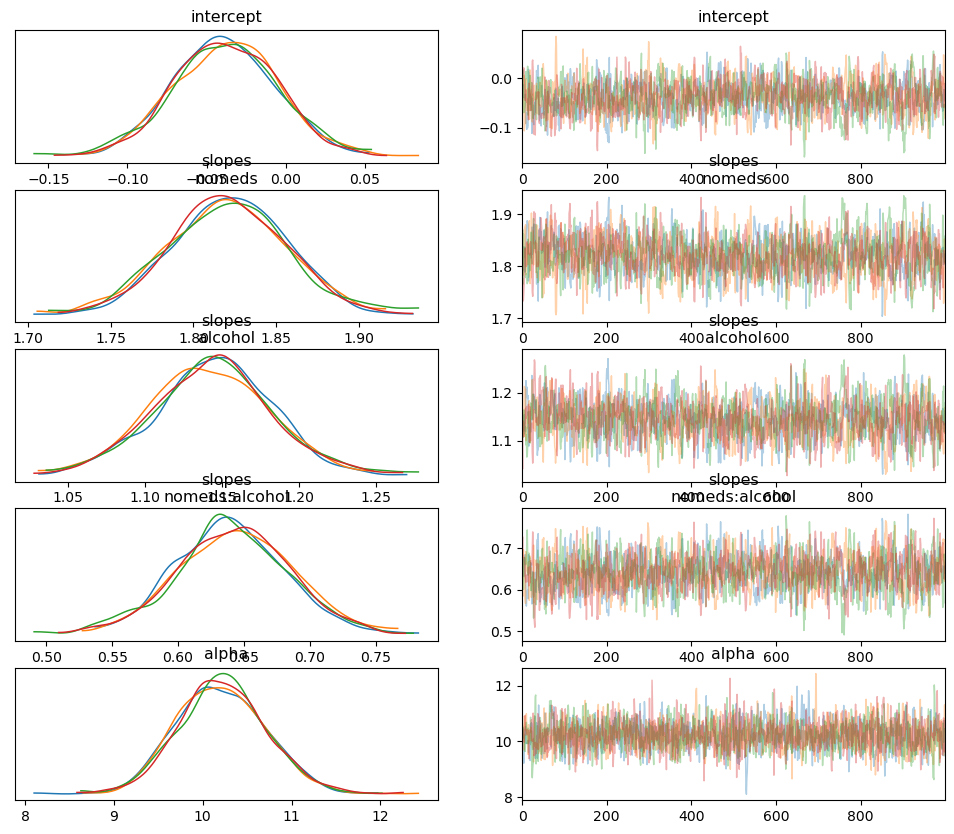

In [7]:
az.plot_trace(idata, compact=False);

In [8]:
# Transform coefficients to recover parameter values
az.summary(np.exp(idata.posterior), kind="stats", var_names=["intercept", "slopes"])

,mean,sd,hdi_3%,hdi_97%
intercept,0.963,0.032,0.902,1.022
slopes[nomeds],6.182,0.225,5.786,6.633
slopes[alcohol],3.141,0.121,2.923,3.383
slopes[nomeds:alcohol],1.901,0.082,1.753,2.063


In [9]:
az.summary(idata.posterior, kind="stats", var_names="alpha")

,mean,sd,hdi_3%,hdi_97%
alpha,10.213,0.5,9.328,11.167


In [10]:
with m_sneeze_inter:
    y = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [y]


In [11]:
y.posterior_predictive['y'].shape

(4, 1000, 4000)

In [12]:
len(df)

4000

In [13]:
y_pred = []
for i in range(len(df)):
    y_pred.append(np.median(y.posterior_predictive['y'][:, :, i]))

In [14]:
np.array(y_pred).mean()

10.998

In [15]:
df.describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,nsneeze
count,4000.000000
mean,11.348000
std,15.514737
min,0.000000
3%,0.000000
25%,1.000000
50%,4.000000
75%,13.000000
97%,50.000000
max,94.000000


In [16]:
pd.DataFrame(
    {
        "y_pred": y_pred
    }
).describe(percentiles=[0.03, 0.25, 0.5, 0.75, 0.97])

,y_pred
count,4000.000000
mean,10.998000
std,13.443792
min,1.000000
3%,1.000000
25%,2.500000
50%,4.000000
75%,12.750000
97%,34.000000
max,35.000000


In [17]:
y_true = df.nsneeze.values.reshape(-1)
np.abs(y_true - np.array(y_pred)).mean()

3.65125